# Notebook to organize stuff for meeting 

## 1. PHSYPROP

### What is/was it?

PHYSPROP was created by the Syracuse Research Corporation and contains physical constants for a variety of chemicals. Put together from different sources, with description of selection criteria. PHYSPROP however has disappeared since a few years and all sources linking to it are not available anymore. It is now in EPA's (United States Environmental Protection Agency) EPI (Estimation Programs Interface) suite.

In 2016,  people from the EPA did a curation on this dataset, and implemented a KNIME workflow for curation. This workflow is unfortunatley also not available anymore. In this workflow, 2716 '2D-QSAR ready' compoundsd where obtained from the original 3037 compounds in the PHYSPROP database.The OPERA models were build on this database to predict properties using kNN and selected PaDEL 2D molecular descriptors. OPERA predictions are now displayed for compounds when you search the EPA CompTox Chemicals Dashboard. PHYSPROP is considered a well curated database by others in the field. The database has been dumped on OCHEM, and entries from here make up >80% of the molecules in the working set that are pulled from OCHEM.

When comparing the values reported in this database to the ones in the working set, something interesting was observed:

Shuzhe: 3098
OPERA: 2368
Overlap of Shuzhe and OPERA: 1855
all:  1855
small:  1820
big:  35


/tmp/ipykernel_3504680/1756697899.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


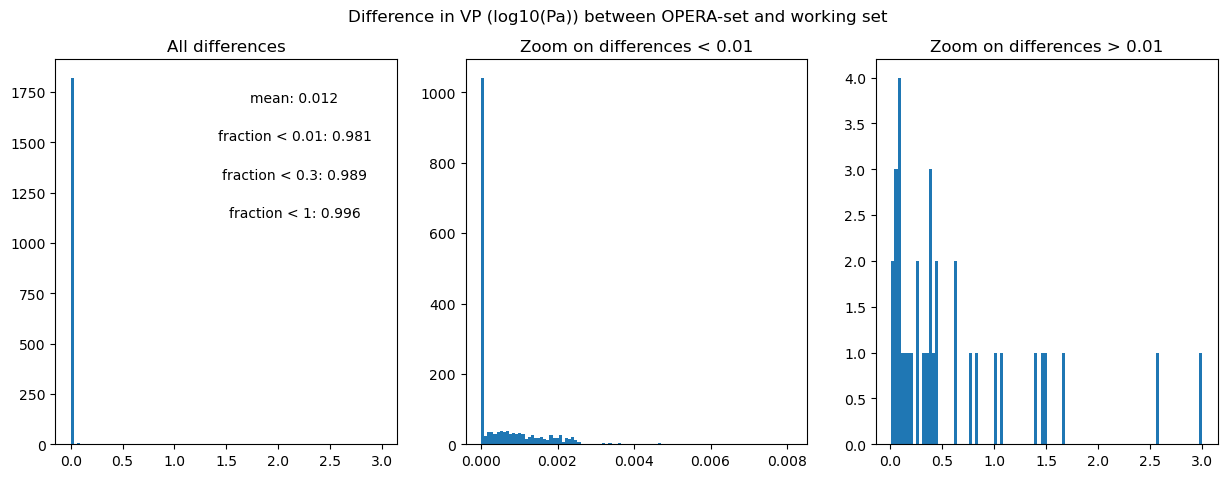

In [135]:
import pandas as pd
df_original_shuze_standardized_298 = pd.read_csv('../tmp_data/df_original_shuze_standardized_298.csv')
df_opera = pd.read_csv('../tmp_data/df_25_opera_standardized.csv')
print('Shuzhe:', df_original_shuze_standardized_298.shape[0])
print('OPERA:', df_opera.shape[0])
#drop 'SMILES' column
df_combined = df_opera.drop(columns=['SMILES'])
df_combined = df_combined.rename(columns={'VP logPa':'VP_logPA_OPERA'})
df_combined = df_combined.drop(columns=['standardized_smiles'])
df_combined = df_combined.drop_duplicates(subset=['inchikey'])
df_combined = df_combined.set_index('inchikey')
df_original_shuze_standardized_298 = df_original_shuze_standardized_298.set_index('inchikey')
df_combined = df_combined.join(df_original_shuze_standardized_298, how='inner')
df_combined = df_combined.reset_index()
print('Overlap of Shuzhe and OPERA:', df_combined.shape[0])
#add colum with difference between Shuzhe and OPERA
df_combined['vp_log10pa_diff'] = abs(df_combined['VP_logPA_OPERA'] - df_combined['VP_logPA_shuze'])
all_diffs = df_combined['vp_log10pa_diff'].to_list()
small_diffs = df_combined[df_combined['vp_log10pa_diff'] < 0.01]['vp_log10pa_diff'].to_list()    
big_diffs = df_combined[df_combined['vp_log10pa_diff'] >= 0.01]['vp_log10pa_diff'].to_list()
#print lenghts
print("all: ", len(all_diffs))
print("small: ", len(small_diffs))
print("big: ", len(big_diffs))
import matplotlib.pyplot as plt
import numpy as np
#3 histograms in one row: all, 0-0.3, 0.3-max
plt, fig = plt.subplots(1,3, figsize=(15,5))
fig[0].hist(all_diffs, bins=100)
fig[0].set_title('All differences')
fig[1].hist(small_diffs, bins=100)
fig[1].set_title('Zoom on differences < 0.01')
fig[2].hist(big_diffs, bins=100)
fig[2].set_title('Zoom on differences > 0.01')
#set global title
plt.suptitle('Difference in VP (log10(Pa)) between OPERA-set and working set')
#add mean, fraction < 0.01, fraction < 0.3, fraction < 1
fig[0].text(0.7, 0.9, "mean: " + str(round(df_combined['vp_log10pa_diff'].mean(), 3)), horizontalalignment='center', verticalalignment='center', transform=fig[0].transAxes)
fig[0].text(0.7, 0.8, "fraction < 0.01: " + str(round(len(small_diffs)/len(all_diffs), 3)), horizontalalignment='center', verticalalignment='center', transform=fig[0].transAxes)
fig[0].text(0.7, 0.7, "fraction < 0.3: " + str(round(len(df_combined[df_combined['vp_log10pa_diff'] < 0.3])/len(all_diffs), 3)), horizontalalignment='center', verticalalignment='center', transform=fig[0].transAxes)
fig[0].text(0.7, 0.6, "fraction < 1: " + str(round(len(df_combined[df_combined['vp_log10pa_diff'] < 1])/len(all_diffs), 3)), horizontalalignment='center', verticalalignment='center', transform=fig[0].transAxes)
plt.show()

In [141]:
#can we get the source according to original df for these compounds?
df_original = pd.read_csv('../tmp_data/df_original_shuze_standardized_298.csv')
#get inchikeys of compounds with big differences
big_diffs_inchikeys = df_combined[df_combined['vp_log10pa_diff'] >= 0.3]['inchikey'].to_list()
#filter original df by inchikeys
df_original_big_diff = df_original[df_original['inchikey'].isin(big_diffs_inchikeys)]
print(len(df_original_big_diff))
df_original_big_diff['Source'].value_counts()

21


Source
OCHEM            11
REACH             5
PUBCHEM           4
PUBCHEM;REACH     1
Name: count, dtype: int64

In [2]:
#one might as if these points are the major outliers when we do the cross validation
from sandbox_utils import train_grouped_kfold
df_features =  pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/tmp_data/Current_set_2980_all_features_vp_in_log10_Pa.csv')
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
RDKit_feature_names = pd.read_pickle('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/outputs/RDKit_2D_descriptors.pkl')
outputs_overlap_shuze = train_grouped_kfold(df_features,params,RDKit_feature_names,name='PhysChem_working_set',split_on = 'molregno',y='vp_log10pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.1736306519993551


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.2141147234183705


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.0271275388761767


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.3387219010601783


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.1447794553466555


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.2509976141570467


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.2070062818914176


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 1.250887151026834


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 1.2901680177191746


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 1.169127920022414


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 1.2095637039415361


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 1.2329581135019805


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 1.2192952420551644


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.193450503386473


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 1.1434165715154816


In [3]:
#make df from these reals, predictions and molregnos
from rdkit import Chem
reals = outputs_overlap_shuze[0]
preds = outputs_overlap_shuze[1]
molregnos = outputs_overlap_shuze[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
molregnos_flat = [item for sublist in molregnos for item in sublist]
df_overlap_shuze_preds = pd.DataFrame({'real': reals_flat, 'pred': preds_flat, 'molregno': molregnos_flat})
df_overlap_shuze_preds
#average over molregnos
df_overlap_shuze_preds_avg = df_overlap_shuze_preds.groupby(['molregno']).mean()
df_overlap_shuze_preds_avg
#make a new combined df of df_features_overlap and df_overlap_shuze_preds_avg
df_features_overlap_shuze = pd.merge(df_features, df_overlap_shuze_preds_avg, on=['molregno'], how='inner')
df_features_overlap_shuze['inchikey'] = df_features_overlap_shuze.apply(lambda row: Chem.MolToInchiKey(Chem.MolFromSmiles((row['standardized_smiles']))), axis=1)
#now also add a column with the value from opera, based on inchi
df_features_overlap_shuze_opera = pd.merge(df_features_overlap_shuze, df_combined, on=['inchikey'], how='inner', suffixes=('_shuze', '_opera'))
df_features_overlap_shuze_opera

,confid,molregno,mdfp,NumHeavyAtoms,NumRotatableBonds,NumN,NumO,NumF,NumP,NumS,...,inchikey,VP log mmHg,VP_logPA_OPERA,hash_code_opera,SMILES_opera,Temperature_opera,VP_logPA_shuze,Source_opera,standardized_smiles_opera,vp_log10pa_diff
0,2298,1,"[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.4462820500696...",6,0,0,0,0,0,0,...,UHOVQNZJYSORNB-UHFFFAOYSA-N,1.976800,4.101702,60c5fa2eb3046aca250f27ede97fbe7a,[cH]1:[cH]:[cH]:[cH]:[cH]:[cH]:1,298.15,4.100855,PUBCHEM;OCHEM,c1ccccc1,0.000847
1,1151,8,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",13,1,0,2,0,0,0,...,UOBYKYZJUGYBDK-UHFFFAOYSA-N,-5.178200,-3.053298,0029fb907f0382cb8ba7913301e791ec,[O]=[C](-[OH])-[c]1:[cH]:[cH]:[c]2:[cH]:[cH]:[...,298.15,-3.053323,OCHEM,O=C(O)c1ccc2ccccc2c1,0.000024
2,1152,9,"[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, 0.4848459757350...",5,2,0,1,0,0,0,...,HRQGCQVOJVTVLU-UHFFFAOYSA-N,1.468300,3.593202,0050ebd8f62aa0dd9dd972b02e277f5b,[Cl]-[CH2]-[O]-[CH2]-[Cl],298.15,3.591625,OCHEM,ClCOCCl,0.001577
3,1154,11,"[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.104781552046...",4,0,0,0,1,0,0,...,UMNKXPULIDJLSU-UHFFFAOYSA-N,3.134199,5.259101,008d2fdb5a446f17a72a38e339f4a351,[F]-[CH](-[Cl])-[Cl],298.15,5.260000,OCHEM,FC(Cl)Cl,0.000899
4,1155,12,"[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -105.003804343...",13,3,0,3,0,0,0,...,WHKUVVPPKQRRBV-UHFFFAOYSA-N,-5.229100,-3.104198,0098a5056ebdd5b821285efdeb1a2a95,[CH3]-[c]1:[cH]:[c](-[Cl]):[cH]:[cH]:[c]:1-[O]...,298.15,-3.104246,OCHEM,Cc1cc(Cl)ccc1OCC(=O)O,0.000048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812,4234,4236,"[5, 1, 0, 0, 0, 0, 0, 0, 2, 0, -3.480116756173...",5,1,0,0,0,0,0,...,XFNJYAKDBJUJAJ-UHFFFAOYSA-N,0.894400,3.019302,fed6bb50ab9252c14ee64cd634c936bf,[CH3]-[CH](-[Br])-[CH2]-[Br],298.15,3.020000,OCHEM,CC(Br)CBr,0.000698
1813,4236,4238,"[9, 0, 1, 0, 0, 0, 0, 0, 0, 0, -124.1646445639...",9,0,1,0,0,0,0,...,VVAKEQGKZNKUSU-UHFFFAOYSA-N,-1.124900,1.000002,ff0911fce8022fecf311abe80dc440fc,[CH3]-[c]1:[cH]:[cH]:[cH]:[c](-[NH2]):[c]:1-[CH3],298.15,0.999963,OCHEM,Cc1cccc(N)c1C,0.000039
1814,4237,4239,"[6, 2, 0, 3, 0, 0, 0, 0, 0, 0, 103.38549113357...",6,2,0,3,0,0,0,...,PEDCQBHIVMGVHV-UHFFFAOYSA-N,-3.774701,-1.649799,ff3029d842193ea04536d8d4e79a6745,[OH]-[CH2]-[CH](-[OH])-[CH2]-[OH],298.15,-1.650000,OCHEM,OCC(O)CO,0.000201
1815,4239,4241,"[17, 0, 0, 1, 0, 0, 0, 4, 0, 0, 0.034004099168...",17,0,0,1,0,0,0,...,NSDXKMRVQOSASS-UHFFFAOYSA-N,-7.481501,-5.356599,ff3ac5bdeb6e4683f822395b116dda7f,[Cl]-[c]1:[cH]:[c](-[Cl]):[c]2:[o]:[c]3:[c](-[...,298.15,-5.356584,OCHEM,Clc1cc(Cl)c2oc3c(Cl)c(Cl)ccc3c2c1,0.000014


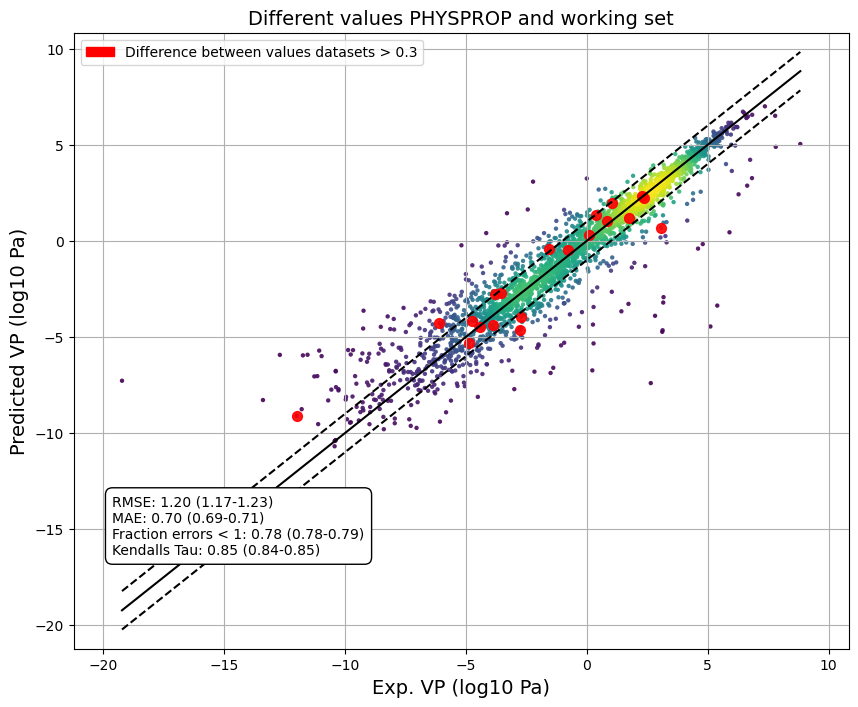

In [4]:
from sandbox_utils import density_plot_single_outliers
df_features_overlap_shuze_opera['big_diff'] = np.where(df_features_overlap_shuze_opera['vp_log10pa_diff'] > 0.3, 'blue', 'red')
reals_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['real'].tolist()]
predictions_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['pred'].tolist()]
molregnos_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['molregno'].tolist()]
density_plot_single_outliers(reals = [outputs_overlap_shuze[0]], predictions = [outputs_overlap_shuze[1]], molregnos = [outputs_overlap_shuze[2]], outliers_reals=reals_outliers, outliers_predictions=predictions_outliers, outliers_molregnos=molregnos_outliers, title='Different values PHYSPROP and working set', name='overlap_shuze_opera_outliers')

now change these values to the opera values and rerun

In [5]:
#make a new colum: new_vp_log10pa. Here should go: the value for this inchikey if the inchikey is in the OPERA set, otherwise vp_log10pa
#first: add to df_features a column new_vp_log10pa, with the value from df_combined (or value from vp_log10pa if not in df_combined)
df_features['inchikey'] = df_features.apply(lambda row: Chem.MolToInchiKey(Chem.MolFromSmiles((row['standardized_smiles']))), axis=1)
df_features['new_vp_log10pa'] = df_features.apply(lambda row: df_combined[df_combined['inchikey'] == row['inchikey']]['VP_logPA_OPERA'].values[0] if row['inchikey'] in df_combined['inchikey'].values else row['vp_log10pa'], axis=1)

In [6]:
#train model on these new values
outputs_corrected = train_grouped_kfold(df_features,params,RDKit_feature_names,name='PhysChem_working_set_corrected',split_on = 'molregno',y='new_vp_log10pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 1.2057256209017506


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 1.1974627463521224


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.1470209013557395


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.3251859665410348


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 1.135063085542829


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 1.1984683555609197


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.115106568196169


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 1.3180449603090032


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 1.3303222556411989


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 1.162726568044715


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 1.18125716835847


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 1.2289776814648563


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 1.2927439040639312


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.1695932485340133


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 1.1059940731919304


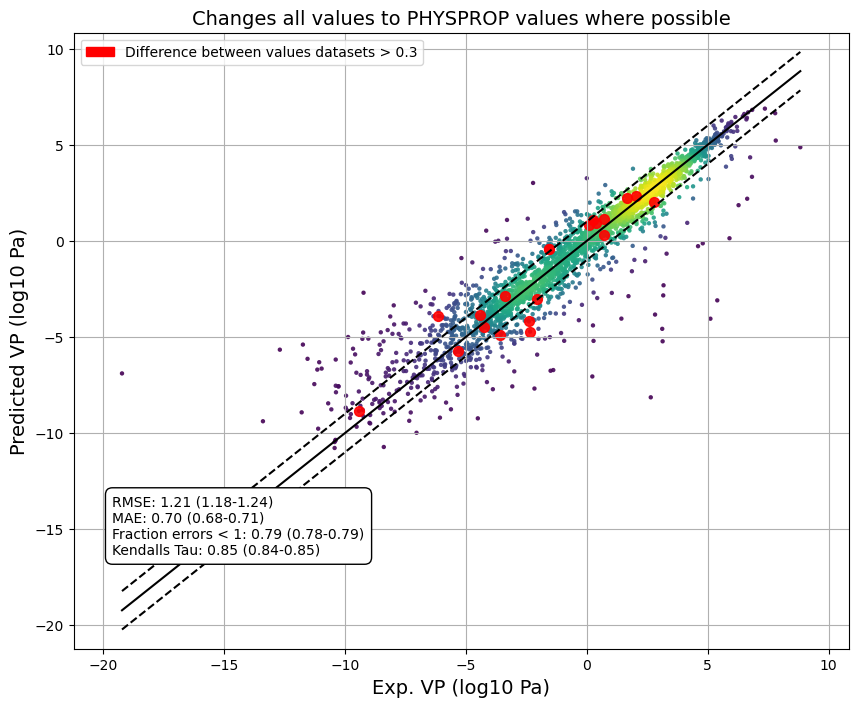

In [7]:
#same thing
#make df from these reals, predictions and molregnos
from rdkit import Chem
reals = outputs_corrected[0]
preds = outputs_corrected[1]
molregnos = outputs_corrected[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
molregnos_flat = [item for sublist in molregnos for item in sublist]
df_overlap_shuze_preds = pd.DataFrame({'real': reals_flat, 'pred': preds_flat, 'molregno': molregnos_flat})
df_overlap_shuze_preds
#average over molregnos
df_overlap_shuze_preds_avg = df_overlap_shuze_preds.groupby(['molregno']).mean()
df_overlap_shuze_preds_avg
#make a new combined df of df_features_overlap and df_overlap_shuze_preds_avg
df_features_overlap_shuze = pd.merge(df_features, df_overlap_shuze_preds_avg, on=['molregno'], how='inner')
df_features_overlap_shuze['inchikey'] = df_features_overlap_shuze.apply(lambda row: Chem.MolToInchiKey(Chem.MolFromSmiles((row['standardized_smiles']))), axis=1)
#now also add a column with the value from opera, based on inchi
df_features_overlap_shuze_opera = pd.merge(df_features_overlap_shuze, df_combined, on=['inchikey'], how='inner', suffixes=('_shuze', '_opera'))
from sandbox_utils import density_plot_single_outliers
df_features_overlap_shuze_opera['vp_log10pa_diff'] = abs(df_features_overlap_shuze_opera['new_vp_log10pa'] - df_features_overlap_shuze_opera['vp_log10pa'])
df_features_overlap_shuze_opera['big_diff'] = np.where(df_features_overlap_shuze_opera['vp_log10pa_diff'] > 0.3, 'blue', 'red')
reals_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['real'].tolist()]
predictions_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['pred'].tolist()]
molregnos_outliers = [df_features_overlap_shuze_opera[df_features_overlap_shuze_opera['big_diff'] == 'blue']['molregno'].tolist()]
density_plot_single_outliers(reals = [outputs_corrected[0]], predictions = [outputs_corrected[1]], molregnos = [outputs_corrected[2]], outliers_reals=reals_outliers, outliers_predictions=predictions_outliers, outliers_molregnos=molregnos_outliers, title='Changes all values to PHYSPROP values where possible', name='overlap_shuze_opera_outliers')

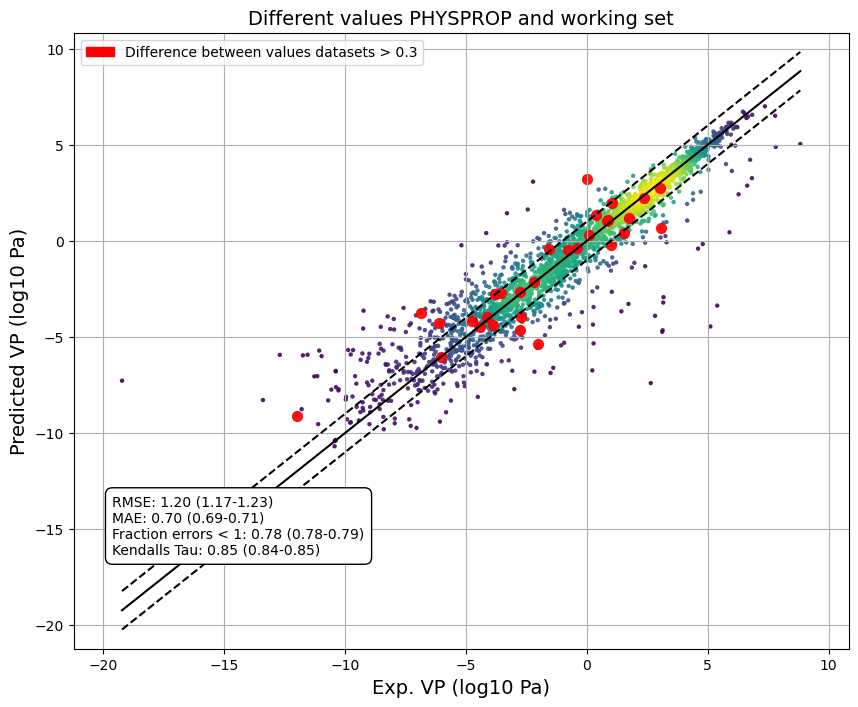

Interesting: especially for this lowest value, it was predicted better before. Overall more points outside the dashed lines. 

show how good we would do on only PHYSPROP vs on our current set using cross validation

In [8]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res
standardized_smiles = df_opera.standardized_smiles.to_list()
mols = [Chem.MolFromSmiles(smi) for smi in standardized_smiles]
allDescrs = [getMolDescriptors(m) for m in mols]
df_opera = df_opera.reset_index(drop=True)
df_opera = df_opera.join(pd.DataFrame(allDescrs))
df_opera.head()


,SMILES,VP log mmHg,VP logPa,standardized_smiles,inchikey,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CC(O)C(=O)O,-1.089900,1.035002,CC(O)C(=O)O,JVTAAEKCZFNVCJ-UHFFFAOYSA-N,9.449074,9.449074,1.185185,-1.231481,0.453936,...,0,0,0,0,0,0,0,0,0,0
1,O=C(O)c1c(Cl)ccc(Cl)c1Cl,-3.259600,-1.134698,O=C(O)c1c(Cl)ccc(Cl)c1Cl,XZIDTOHMJBOSOX-UHFFFAOYSA-N,10.567284,10.567284,0.030864,-1.187500,0.744344,...,0,0,0,0,0,0,0,0,0,0
2,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,-8.260400,-6.135498,c1ccc2c(c1)cc1ccc3cccc4ccc2c1c34,FMMWHPNWAFZXNH-UHFFFAOYSA-N,2.309074,2.309074,1.317945,1.317945,0.243454,...,0,0,0,0,0,0,0,0,0,0
3,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,-6.719001,-4.594099,COC(=O)C1C(OC(=O)c2ccccc2)CC2CCC1N2C,ZPUCINDJVBIVPJ-UHFFFAOYSA-N,12.296709,12.296709,0.097012,-0.408467,0.797936,...,0,0,0,0,0,0,0,0,0,0
4,O=C(O)c1cccc(Cl)c1Cl,-3.642099,-1.517198,O=C(O)c1cccc(Cl)c1Cl,QAOJBHRZQQDFHA-UHFFFAOYSA-N,10.430895,10.430895,0.027006,-1.071759,0.740184,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_opera_unique = df_opera.drop_duplicates(subset=['inchikey'])
outputs_physprop = train_grouped_kfold(df_opera_unique,params,RDKit_feature_names,name='PHYSPROP',split_on = 'inchikey',y='VP logPa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 0.9264436847405398


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 0.831915858272978


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.03549641435185


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 1.0130920682598004


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 0.8117454498953166


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 0.9016776506954571


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.0087671503566704


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 0.8431216641222568


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 0.9347828400769028


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 0.8931522208995475


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 0.8948000287480995


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 0.9610066925313723


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 0.8380595521515379


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 0.861977447335343


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 0.9912343066011822


making 2 plots
plot 1 of 2
2368 points
plot 2 of 2
2980 points


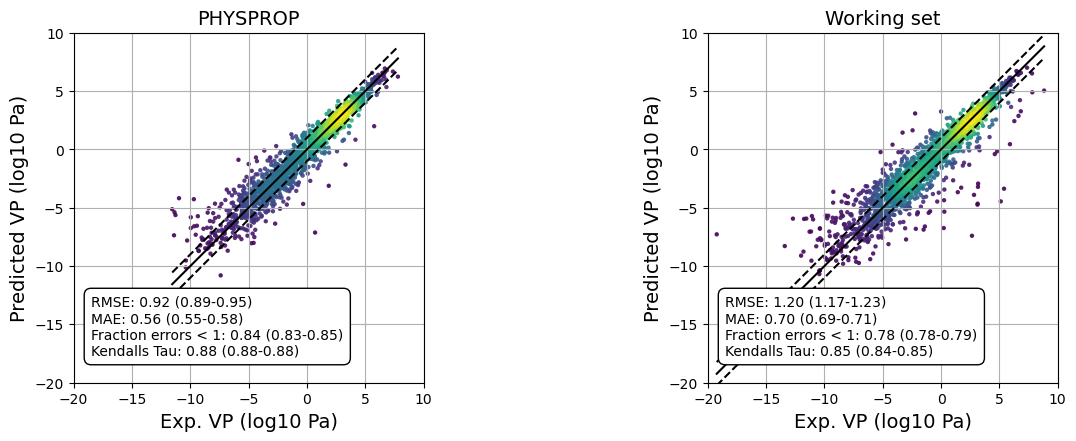

In [11]:
from sandbox_utils import density_plot_multiple_custom
density_plot_multiple_custom(reals = [outputs_physprop[0], outputs_overlap_shuze[0]], predictions = [outputs_physprop[1], outputs_overlap_shuze[1]], molregnos = [outputs_physprop[2], outputs_overlap_shuze[2]], titles=['PHYSPROP', 'Working set'], name='Performance_PHYSPROP_working_set',bounds = [-20, 10])

/tmp/ipykernel_3504680/1652285573.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


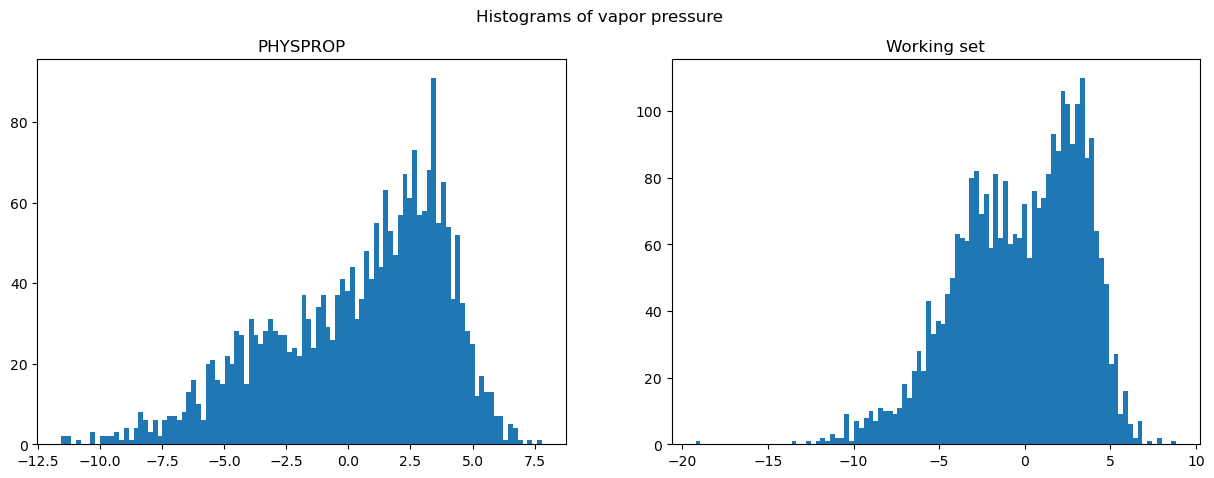

In [13]:
#plot histograms of vapor pressure for df_opera_unique and df_features
import matplotlib.pyplot as plt
import numpy as np
plt, fig = plt.subplots(1,2, figsize=(15,5))
fig[0].hist(df_opera_unique['VP logPa'], bins=100)
fig[0].set_title('PHYSPROP')
fig[1].hist(df_features['vp_log10pa'], bins=100)
fig[1].set_title('Working set')
#set global title
plt.suptitle('Histograms of vapor pressure')
plt.show()

Working set: more lower values, and peak between -5 and 0

Can be used for:
- Curation of current set
- Expansion of current set
- Use as test-test


## REACH evaluation paper

- Goal: Investigate the availability and quality of the data in the ECHA database 
- Method: Evaluation of COSMOtherm against experimental data in the ECHA database 
- Major finding (general): data agree (within some variability) for many of the endpoints. However, there are also certain ranges with substantial discrepancies. 


They use performance of their method on PHYSPROP as way to evaluate their method, reasoning that if it does well on a curated dataset, it should be a good method and can indicate errors in uncurated datasets. As their main focus was on the REACH database, they calculated for these compounds. There was an overlap of ~850 molecules, and for these they show how their model does, and get an RMSE of 0.89 and MAE of 0.48 (logPa).

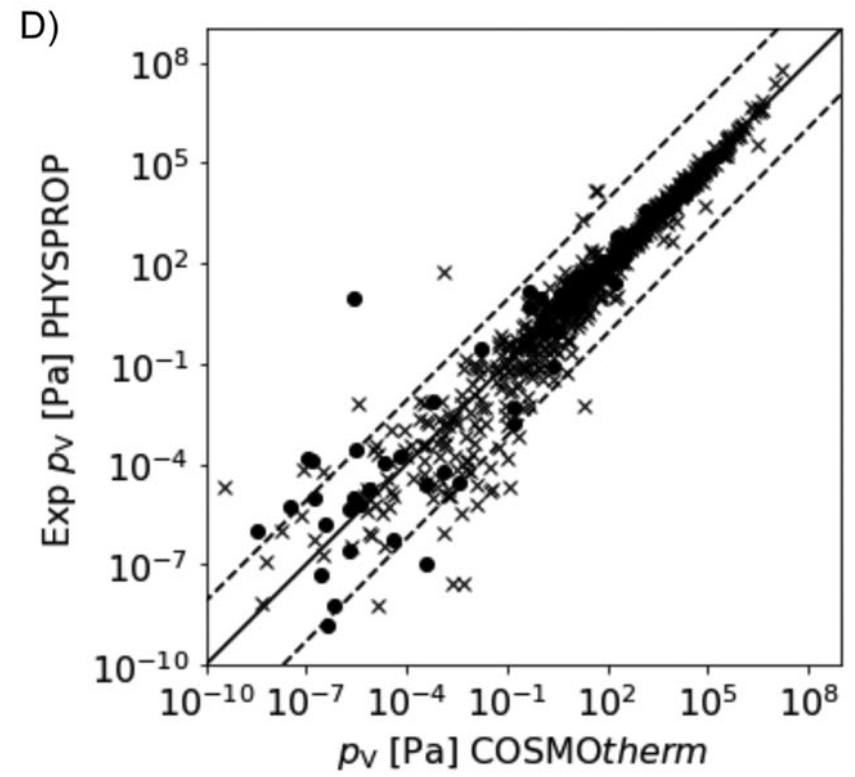

## Open question:
What can we do with this? I don't know much about COSMO, but from what I have read, it seems accurate? And this does show something, but is it enough? Can also be that REACH has different type of chemical, and that COSMO works well for the type of molecules in the PHYSPROP database but not well for the ones in the REACH database?

If we accept the assumptions from the author, we can identify a few issues in the REACH database:
- Molecules that in reality have a very low vapor pressure, are registered with a higher vapor pressure, perhaps due to incapacity of the measuring techniques
- Values with no qualifyer or qualifer "ca." can be way off
- There are many values for which COSMO calculates vapor pressures outside of the validated range
- None of the methods worked well on low vapor pressures
- No results below 10^-6 should be trusted, other ranges depend on what technique was used

Some findings that are usefull regardless:
- A lot of vapor pressure are measured using inappropriate techniques

What can we do with this? A few things. We could experiment with using COSMO values. However, using calculated values is not desirable, but maybe could be that for this case, these are more trustworthy then the actual experiment? Either way, if we can pull more descriptive data (data inherited from ShuZe does not contain a lot of information), and do a new filtering, e.g. based on techniques used, making sure the values are measured according to SOP etc. Alternatively, we can use some criteria from this paper and link to data we already have as a way to curate the data. If we do this, for what we can do with currently available data, we get 1187 values from REACH.

## Naef and Acree paper

Set of 2071 molecules from. Biggest chunks from D. Mackay’s Handbook and a collection from M. H. Abraham and W. E. Acree Jr, as well as over 200 papers. Got a comment, mostly with complaints about claims of novelty and performance of the model. However, also some complaints about the data (specifaclly for another datapoint, heat of formation, but might also hold true for vapor pressure). Mostly: obtained from large number of papers, and 'curation' was done by removing compounds that were far off in their predicitions. The final set available consists of 2071 vapor pressures. Cross-validating a model on just this set gives amazing results:


In [27]:
df_naef = pd.read_csv('NAEF_features_compact_298K.csv')
#drop duplicates in inchikey
df_naef = df_naef.drop_duplicates(subset=['inchikey'])
output_naef = train_grouped_kfold(df_naef,params,RDKit_feature_names,name='NAEF',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 0.5387108530878835


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 0.6085208503734978


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 0.8947183194169283


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 0.6732686646039558


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 0.6051988941420887


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 0.5019075678983108


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 0.5552566348978508


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 0.7761022014091957


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 0.6082106952548995


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 0.4027517325395433


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 0.5134054416252611


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 0.5903364592819438


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 0.5280071622198402


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 0.5033252577913038


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 0.5678505920726741


making 3 plots
plot 1 of 3
2368 points
plot 2 of 3
2980 points
plot 3 of 3
2070 points


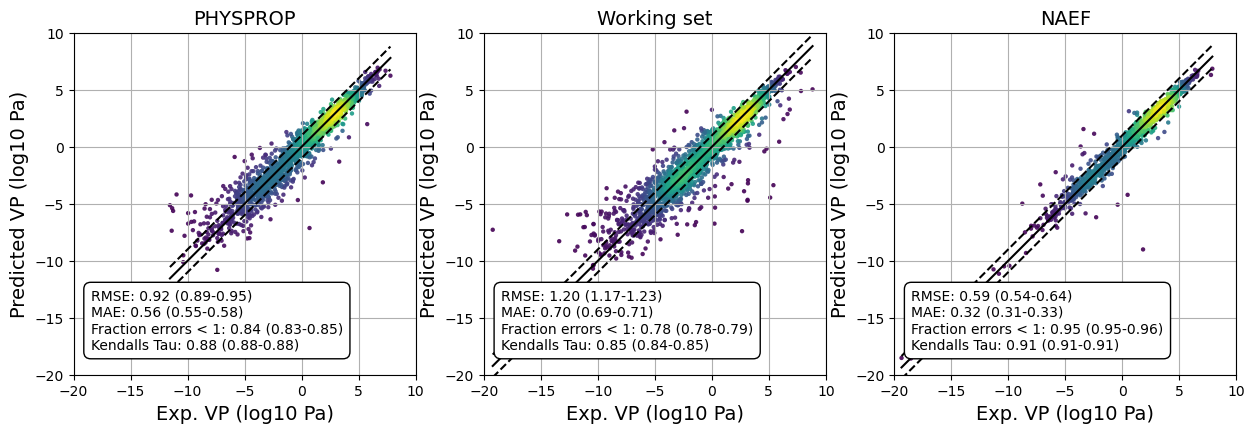

In [30]:
#plot this next to the other two
from sandbox_utils import density_plot_multiple_custom
density_plot_multiple_custom(reals = [outputs_physprop[0], outputs_overlap_shuze[0], output_naef[0]], predictions = [outputs_physprop[1], outputs_overlap_shuze[1], output_naef[1]], molregnos = [outputs_physprop[2], outputs_overlap_shuze[2], output_naef[2]], titles=['PHYSPROP', 'Working set', 'NAEF'], name='Performance_PHYSPROP_working_set_NAEF',bounds = [-20, 10])

Note that this is much better then COSMOtherm on PHYSPROP (which we said before could be set as realistic limit)

## Combining the sets

Length of dataframe: 5626
Number of unique inchikeys: 3795


/tmp/ipykernel_3504680/4211798986.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_duplicates['log10_VP_Pa'] = df_combined_duplicates['log10_VP_Pa'].astype(float)


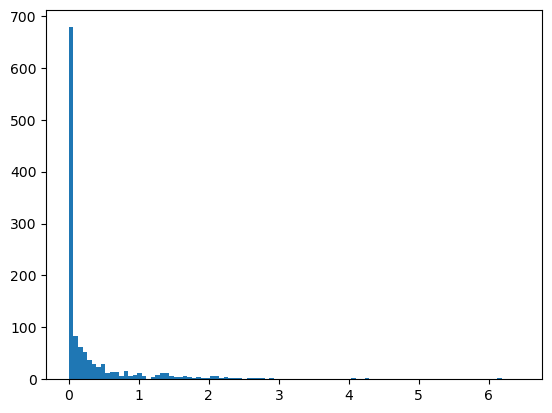

0.3422546634225466 diff smaller then 0.01
0.7347931873479319 diff smaller then 0.3
0.8726682887266829 diff smaller then 1.0


In [126]:
df_physprop = pd.read_csv('PHYSPROP_features_compact_298K.csv')
df_reach = pd.read_csv('REACH_semi_curated_features_compact_298K.csv')
df_naef = pd.read_csv('NAEF_features_compact_298K.csv')
df_physprop['Source'] = 'PHYSPROP'
df_reach['Source'] = 'REACH'
df_naef['Source'] = 'NAEF'
df_combined = pd.concat([df_physprop, df_naef, df_reach])
#move source to first column
df_combined = df_combined[['Source'] + df_combined.columns[:-1].tolist()]
#print lenght of dataframe, and number of unique inchikeys
print('Length of dataframe:', df_combined.shape[0])
print('Number of unique inchikeys:', len(df_combined.inchikey.unique()))
#for duplicate inchikeys, get the max and min value and plot a histogram of the difference
df_combined_duplicates = df_combined[df_combined.duplicated(subset=['inchikey'], keep=False)]
df_combined_duplicates['log10_VP_Pa'] = df_combined_duplicates['log10_VP_Pa'].astype(float)
duplicates_log10_VP_Pa_diffs = []
for duplicate in df_combined_duplicates['inchikey'].unique():
    df_duplicate = df_combined_duplicates[df_combined_duplicates['inchikey'] == duplicate]
    duplicates_log10_VP_Pa_diffs.append(max(df_duplicate['log10_VP_Pa']) - min(df_duplicate['log10_VP_Pa']))
#plot in histogram
import matplotlib.pyplot as plt
plt.hist(duplicates_log10_VP_Pa_diffs,bins='auto')
plt.show()
#print out: percentage within <0.01, <0.3 and <1.0 
print(len([x for x in duplicates_log10_VP_Pa_diffs if x < 0.01])/len(duplicates_log10_VP_Pa_diffs),'diff smaller then 0.01')
print(len([x for x in duplicates_log10_VP_Pa_diffs if x < 0.3])/len(duplicates_log10_VP_Pa_diffs),'diff smaller then 0.3')
print(len([x for x in duplicates_log10_VP_Pa_diffs if x < 1.0])/len(duplicates_log10_VP_Pa_diffs),'diff smaller then 1.0')


As we can see, this combined dataset is not perfect: only a third of the duplicates values are the same, and 25% of them have a difference bigger then 0.3, and more then 10% even bigger then a log unit.

In [45]:
#test: drop duplicate inchikeys, keep the first one. Right now order is PHYSPROP, NAEF, REACH, which should be order of reability
df_combined_unique = df_combined.drop_duplicates(subset=['inchikey'], keep='first')
output_combined = train_grouped_kfold(df_combined_unique,params,RDKit_feature_names,name='Combined',split_on = 'inchikey',y='log10_VP_Pa',n_splits=5,n_repeats=3,random_state=2652124,normalize_x=True)

/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 1: RMSE = 0.8222312676704456


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 2: RMSE = 0.9460028566786463


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 3: RMSE = 1.038277977386928


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 4: RMSE = 0.9637773432141714


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 5: RMSE = 0.923982039535049


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 6: RMSE = 0.8959092145377245


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 7: RMSE = 1.0093931630149982


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 8: RMSE = 0.8668933010399493


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 9: RMSE = 0.9808536405928557


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 10: RMSE = 0.9873048800350636


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 11: RMSE = 0.9633311452043073


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 12: RMSE = 0.8935922760884671


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 13: RMSE = 0.8601146893481068


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 14: RMSE = 1.059055706209668


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fold 15: RMSE = 0.9652223237027534


making 2 plots
plot 1 of 2
2980 points
plot 2 of 2
3795 points


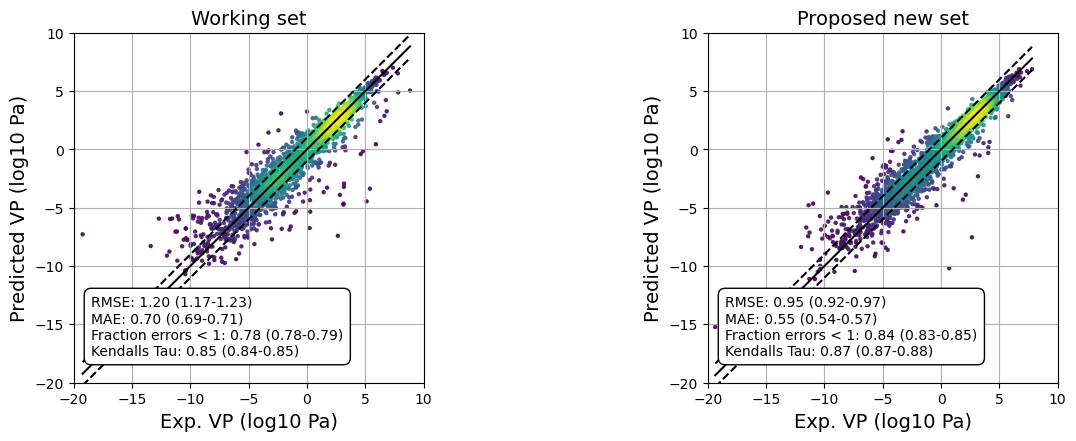

In [47]:
#new plot where we also plot the combined set
from sandbox_utils import density_plot_multiple_custom
density_plot_multiple_custom(reals = [outputs_overlap_shuze[0], output_combined[0]], predictions = [outputs_overlap_shuze[1], output_combined[1]], molregnos = [outputs_overlap_shuze[2], output_combined[2]], titles=['Working set', 'Proposed new set'], name='Performance_working_set_combined',bounds = [-20, 10])

/tmp/ipykernel_3504680/896001291.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


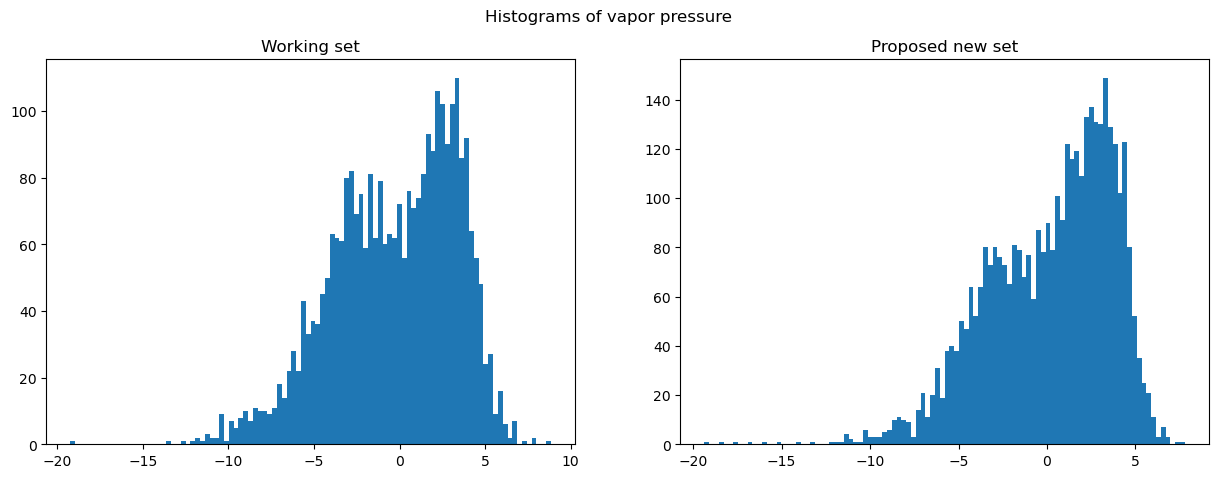

In [51]:
#plot histograms of vp values for proposed new set and working set
import matplotlib.pyplot as plt
import numpy as np
plt, fig = plt.subplots(1,2, figsize=(15,5))
fig[0].hist(df_features['vp_log10pa'], bins=100)
fig[0].set_title('Working set')
fig[1].hist(df_combined_unique['log10_VP_Pa'], bins=100)
fig[1].set_title('Proposed new set')
#set global title
plt.suptitle('Histograms of vapor pressure')
plt.show()

/tmp/ipykernel_3504680/1728655870.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


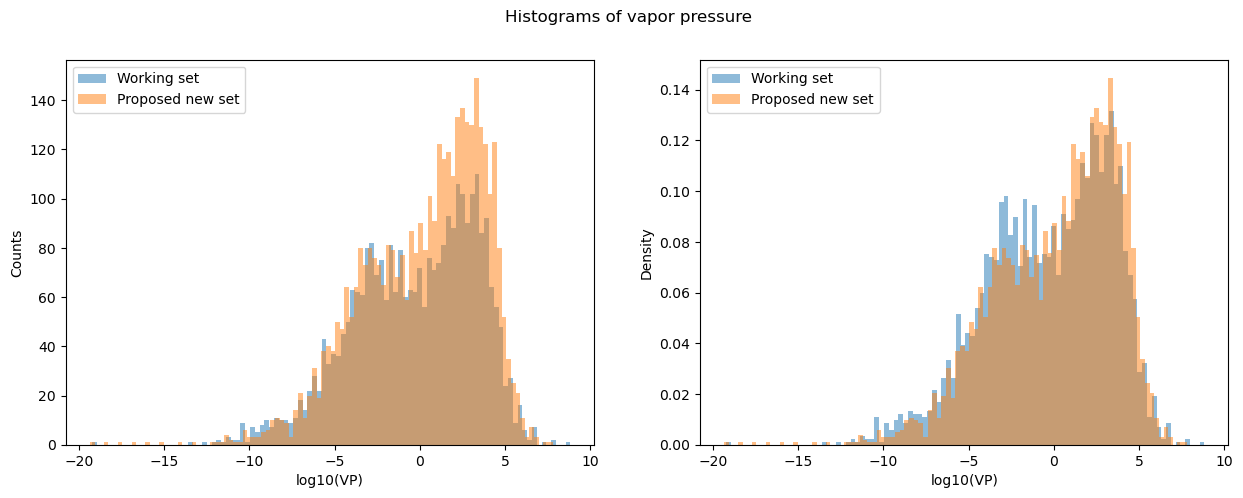

In [59]:
import matplotlib.pyplot as plt
plt, fig = plt.subplots(1,2, figsize=(15,5))
fig[0].hist(df_features['vp_log10pa'], bins=100, alpha=0.5, label='Working set')
fig[0].hist(df_combined_unique['log10_VP_Pa'], bins=100, alpha=0.5, label='Proposed new set')
fig[1].hist(df_features['vp_log10pa'], bins=100, alpha=0.5, label='Working set', density=True)
fig[1].hist(df_combined_unique['log10_VP_Pa'], bins=100, alpha=0.5, label='Proposed new set', density=True)
#add legendsd
fig[0].legend(loc='upper left')
fig[1].legend(loc='upper left')
#add axis labels
fig[0].set_xlabel('log10(VP)')
fig[0].set_ylabel('Counts')
fig[1].set_xlabel('log10(VP)')
fig[1].set_ylabel('Density')
plt.suptitle('Histograms of vapor pressure')
plt.show()

The new set would be relatively similar in sense of vapor pressure values

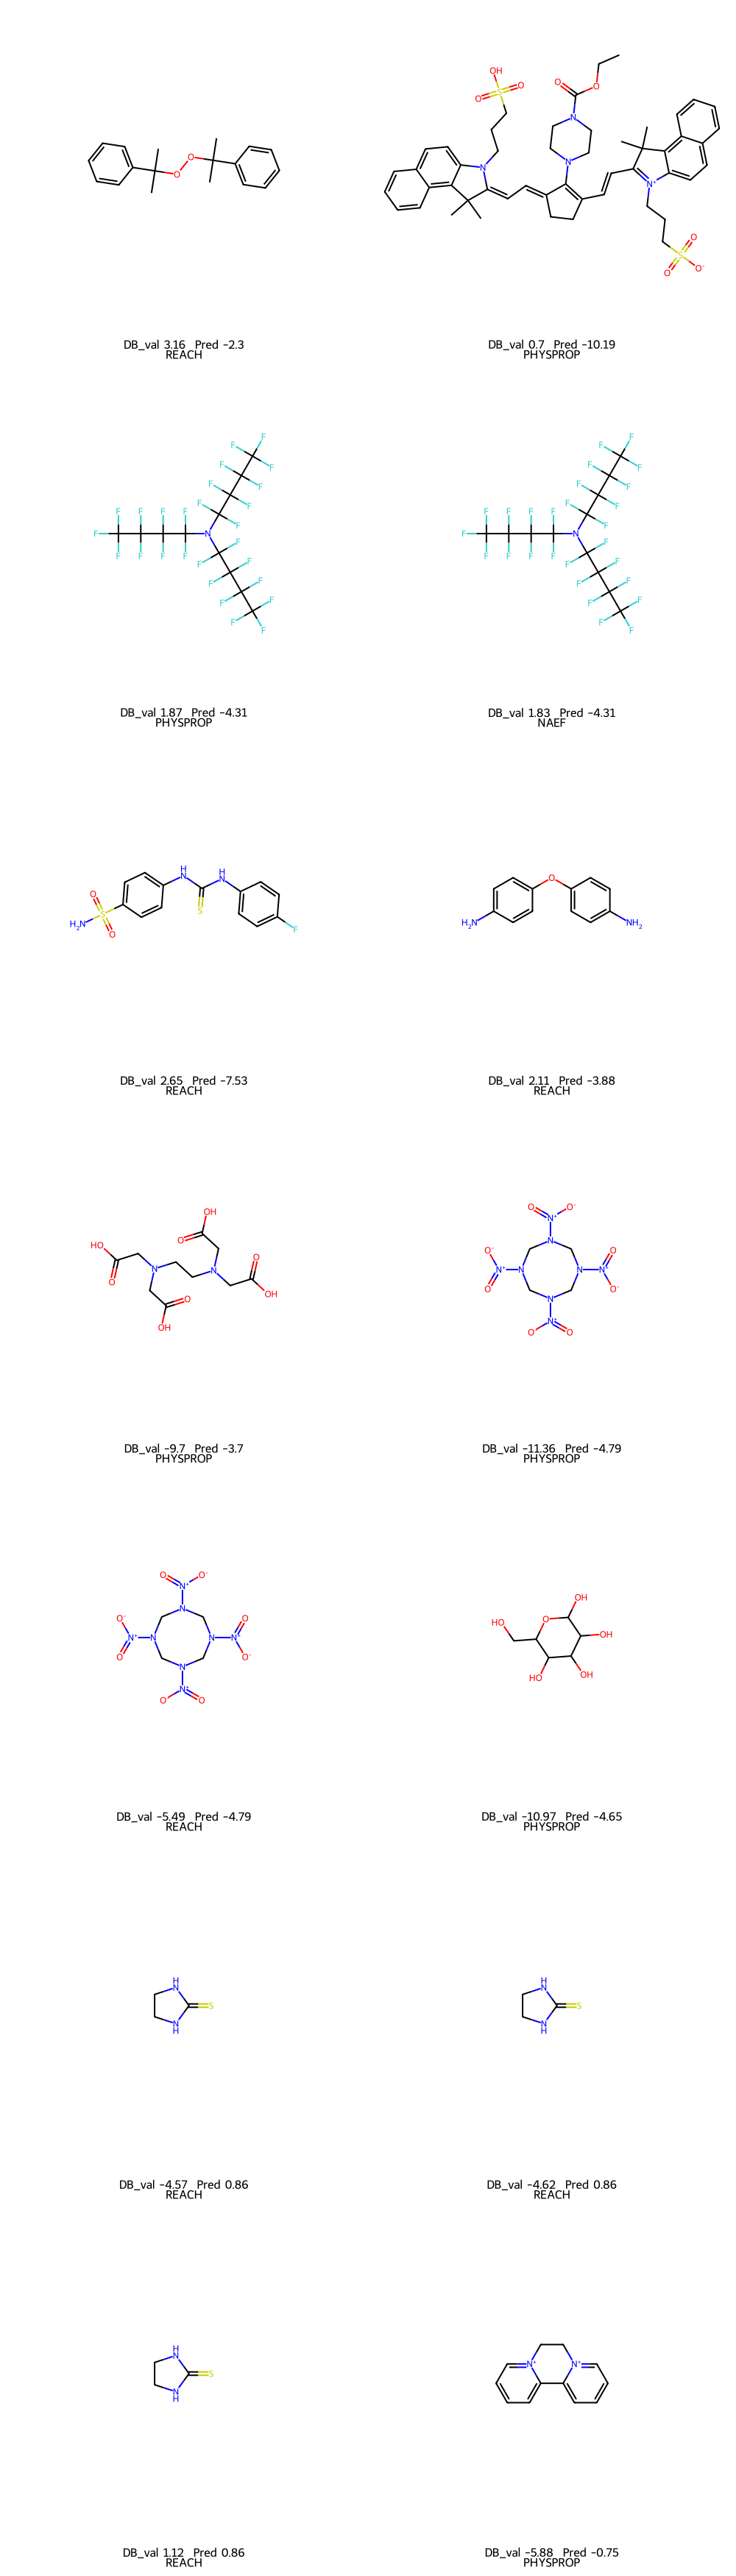

In [134]:
#make a df with the predictions, reals and molregnos of the combined df and look at the biggest outliers
from rdkit import Chem
reals = output_combined[0]
preds = output_combined[1]
molregnos = output_combined[2]
reals_flat = [item for sublist in reals for item in sublist]
preds_flat = [item for sublist in preds for item in sublist]
molregnos_flat = [item for sublist in molregnos for item in sublist]
df_combined_preds = pd.DataFrame({'real': reals_flat, 'pred': preds_flat, 'inchikey': molregnos_flat})
df_combined_preds
#average over molregnos
df_combined_preds_avg = df_combined_preds.groupby(['inchikey']).mean()
df_combined_preds_avg['abs_err'] = abs(df_combined_preds_avg['real'] - df_combined_preds_avg['pred'])
#get where index is JVTAAEKCZFNVCJ-UHFFFAOYSA-N
df_combined_preds_avg
# #sort on abs_err
df_combined_preds_avg = df_combined_preds_avg.sort_values(by=['abs_err'], ascending=False)
df_combined_preds_avg.head(10)
# #for these top10; get all vapor pressures as tupples from the combined df, the sources, and draw them with the values and sources
top10 = df_combined_preds_avg.head(10).index.to_list()
df_combined_top10 = df_combined[df_combined['inchikey'].isin(top10)]
df_combined_top10
#add to these, the predictions, based on inchikeys
df_combined_top10 = pd.merge(df_combined_top10, df_combined_preds_avg, on=['inchikey'], how='inner')
df_combined_top10
#for these, get the smiles, source, pred and log10_VP_Pa
smiles = df_combined_top10['standardized_smiles'].to_list()
sources = df_combined_top10['Source'].to_list()
preds = df_combined_top10['pred'].to_list()
log10_VP_Pa = df_combined_top10['log10_VP_Pa'].to_list()
#combine and sort by smiles, then get the lists again
combined = list(zip(smiles, sources, preds, log10_VP_Pa))
combined.sort(key = lambda x: x[0])
smiles, sources, preds, log10_VP_Pa = zip(*combined)
#make mols
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
#draw
img = Draw.MolsToGridImage(mols, molsPerRow=2, legends=[f'DB_val {round(x[2],2)}\tPred {round(x[1],2)}\n{x[0]}' for x in zip(sources, preds, log10_VP_Pa)], subImgSize=(500,500))
img




1.035002	0.180502	JVTAAEKCZFNVCJ-UHFFFAOYSA-N

In [111]:
# #make dict inchikey_to_smiles from df_combined_unique
# inchikey_to_smiles = dict(zip(df_combined_unique['inchikey'], df_combined_unique['standardized_smiles']))
# #using this dict, make a new column in df_combined_preds_avg
# df_combined_preds['smiles'] = df_combined_preds.apply(lambda row: inchikey_to_smiles[row['inchikey']], axis=1)
# df_combined_preds_avg = df_combined_preds.groupby(['inchikey','smiles']).mean()
# # df_combined_preds_avg['abs_err'] = abs(df_combined_preds_avg['real'] - df_combined_preds_avg['pred'])
# # df_combined_preds_avg = df_combined_preds_avg.sort_values(by=['abs_err'], ascending=False)
# # df_combined_preds_avg.head(10)
# # #for these top10; get all vapor pressures as tupples from the combined df, the sources, and draw them with the values and sources
# # top10 = df_combined_preds_avg.head(10).index.to_list()
# # df_combined_top10 = df_combined[df_combined['inchikey'].isin(top10)]
# # #get the smiles, vp and source, and Draw them
# # from rdkit import Chem
# # from rdkit.Chem import Draw
# # molw_wt = df_combined_top10['MolWt'].to_list()
# # vps = df_combined_top10['log10_VP_Pa'].to_list()
# # smiles = df_combined_top10['standardized_smiles'].to_list()
# # sources = df_combined_top10['Source'].to_list()
# # #get the pred for these
# # preds = df_combined_preds_avg.head(10)['pred'].to_list()
# # #combine and sort by molw_wt, then get the lists again
# # combined = list(zip(smiles, vps, sources, molw_wt, preds))
# # combined.sort(key = lambda x: x[-2])
# # smiles, vps, sources, molw_wt,preds = zip(*combined)
# # #make mols
# # mols = [Chem.MolFromSmiles(smi) for smi in smiles]
# # #draw
# # img = Draw.MolsToGridImage(mols, molsPerRow=5, legends=[f'DB {round(x[0],2)}\t Pred {round(x[2],2)}\n{x[1]}' for x in zip(vps, sources,preds)], subImgSize=(300,300))
# # img
df_combined_preds_avg
df_combined_preds_avg['abs_err'] = abs(df_combined_preds_avg['real'] - df_combined_preds_avg['pred'])
df_combined_preds_avg = df_combined_preds_avg.sort_values(by=['abs_err'], ascending=False)
df_combined_preds_avg.head(10)

,,real,pred,abs_err
inchikey,smiles,,,
ZVTSEGXUAUCYQH-UHFFFAOYSA-N,CCOC(=O)N1CCN(C2=C(/C=C/C3=[N+](CCCS(=O)(=O)[O-])c4ccc5ccccc5c4C3(C)C)CC/C2=C\C=C2/N(CCCS(=O)(=O)O)c3ccc4ccccc4c3C2(C)C)CC1,0.695302,-10.187827,10.883129
VUDOFEJVAFMLEC-UHFFFAOYSA-N,NS(=O)(=O)c1ccc(NC(=S)Nc2ccc(F)cc2)cc1,2.646404,-7.534849,10.181253
UZGLIIJVICEWHF-UHFFFAOYSA-N,O=[N+]([O-])N1CN([N+](=O)[O-])CN([N+](=O)[O-])CN([N+](=O)[O-])C1,-11.356599,-4.786161,6.570438
WQZGKKKJIJFFOK-UHFFFAOYSA-N,OCC1OC(O)C(O)C(O)C1O,-10.970898,-4.652997,6.317902
RVZRBWKZFJCCIB-UHFFFAOYSA-N,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)N(C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F,1.866521,-4.308359,6.174880
KCXVZYZYPLLWCC-UHFFFAOYSA-N,O=C(O)CN(CCN(CC(=O)O)CC(=O)O)CC(=O)O,-9.698998,-3.703306,5.995692
HLBLWEWZXPIGSM-UHFFFAOYSA-N,Nc1ccc(Oc2ccc(N)cc2)cc1,2.113943,-3.880382,5.994325
XMNIXWIUMCBBBL-UHFFFAOYSA-N,CC(C)(OOC(C)(C)c1ccccc1)c1ccccc1,3.162328,-2.304123,5.466451
PDQAZBWRQCGBEV-UHFFFAOYSA-N,S=C1NCCN1,-4.568636,0.863777,5.432414


In [118]:
#get for these inchis, the entries in df_features
bad_inchis = df_combined_preds_avg.head(10).index.to_list()
bad_inchis = [x[0] for x in bad_inchis]
# df_features_top10 = df_features[df_features['inchikey'].isin(bad_inchis)]
# df_features_top10
bad_inchis

['ZVTSEGXUAUCYQH-UHFFFAOYSA-N',
 'VUDOFEJVAFMLEC-UHFFFAOYSA-N',
 'UZGLIIJVICEWHF-UHFFFAOYSA-N',
 'WQZGKKKJIJFFOK-UHFFFAOYSA-N',
 'RVZRBWKZFJCCIB-UHFFFAOYSA-N',
 'KCXVZYZYPLLWCC-UHFFFAOYSA-N',
 'HLBLWEWZXPIGSM-UHFFFAOYSA-N',
 'XMNIXWIUMCBBBL-UHFFFAOYSA-N',
 'PDQAZBWRQCGBEV-UHFFFAOYSA-N',
 'SYJFEGQWDCRVNX-UHFFFAOYSA-N']

650


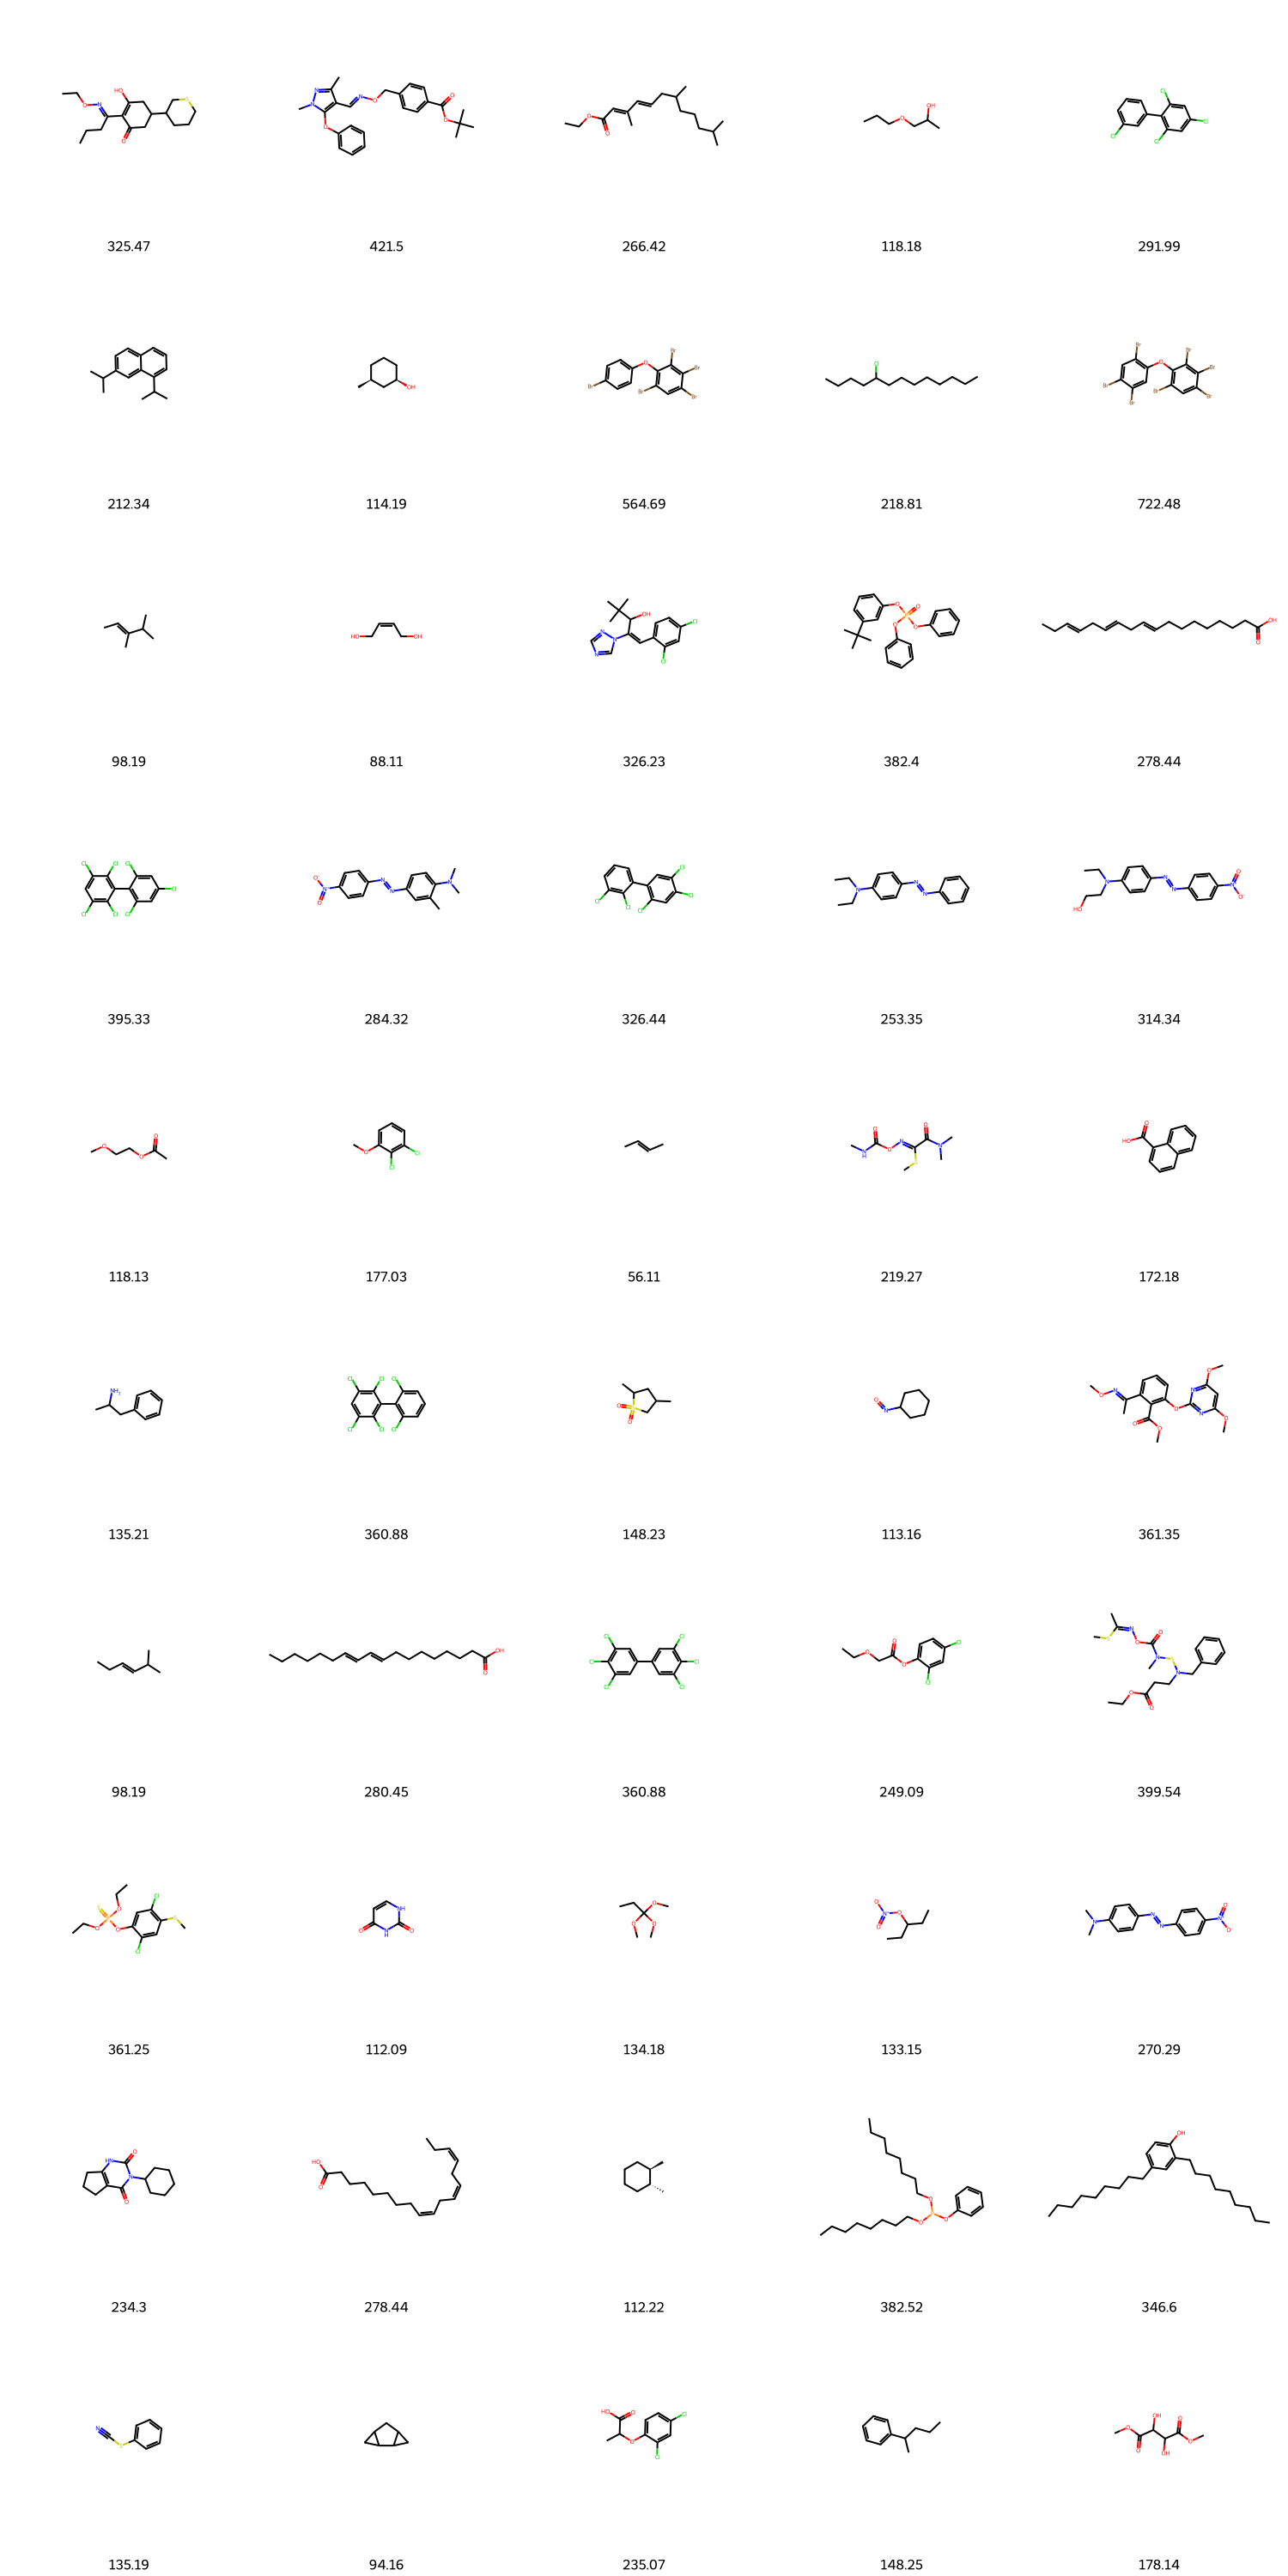

In [149]:
df_missing = df_features[~df_features['inchikey'].isin(df_combined_unique['inchikey'])]
print(len(df_missing))
df_missing['Source'].value_counts()
#draw first 50 with source OCHEM from standardized_smiles
from rdkit import Chem
from rdkit.Chem import Draw
smiles = df_missing[df_missing['Source'] == 'OCHEM']['standardized_smiles'].to_list()
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
molwt = df_missing[df_missing['Source'] == 'OCHEM']['MolWt'].to_list()
img = Draw.MolsToGridImage(mols[:50], molsPerRow=5, subImgSize=(300,300), legends=[f'{round(x,2)}' for x in molwt[:50]])
img